In [1]:
%matplotlib inline
import os, glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NREL-2.5-116

In [2]:
aero_opt_steps = range(4)
aerostruct_opt_steps = range(6)
legendnames = [
    '0: IEA 3.4-130',
    '1: set power rating, rotor size, tower height',
    '2: unconstrainted twist opt',
    '3: unconstrainted twist+chord opt\nincrease minOmega, TSR',
    '4: blade mass opt',
    '5: tower mass opt',
]

In [3]:
figdir = 'figures'
os.makedirs(figdir,exist_ok=True)

In [4]:
prefix = 'NREL-2.5-116'

## reference data

In [5]:
D = 116.
rotor_area = np.pi/4 * D**2

In [6]:
refdata = {
    'GE-2.5-120': '../refdata/GE-2.5-120.csv',
    'GE-2.5-100': '../refdata/GE-2.5-100.csv',
}
markers = ['o','^',]

In [7]:
ref = {}
for refname,refpath in refdata.items():
    print(refpath)
    df = pd.read_csv(refpath,index_col=0,comment='#')
    print(refname,df.columns)
    df = df.rename(columns={'power [kW]':'P','Cp':'Cp_aero','Ct':'Ct_aero'})
    df['P'] *= 1000
    if 'Ct_aero' in df.columns:
        df['T'] = df['Ct_aero'] * 0.5 * 1.225 * (df.index)**2 * rotor_area
    ref[refname] = df

../refdata/GE-2.5-120.csv
GE-2.5-120 Index(['power [kW]', 'Cp', 'Ct'], dtype='object')
../refdata/GE-2.5-100.csv
GE-2.5-100 Index(['power [kW]', 'Cp'], dtype='object')


## aero design

outputs.0/refturb_output.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl


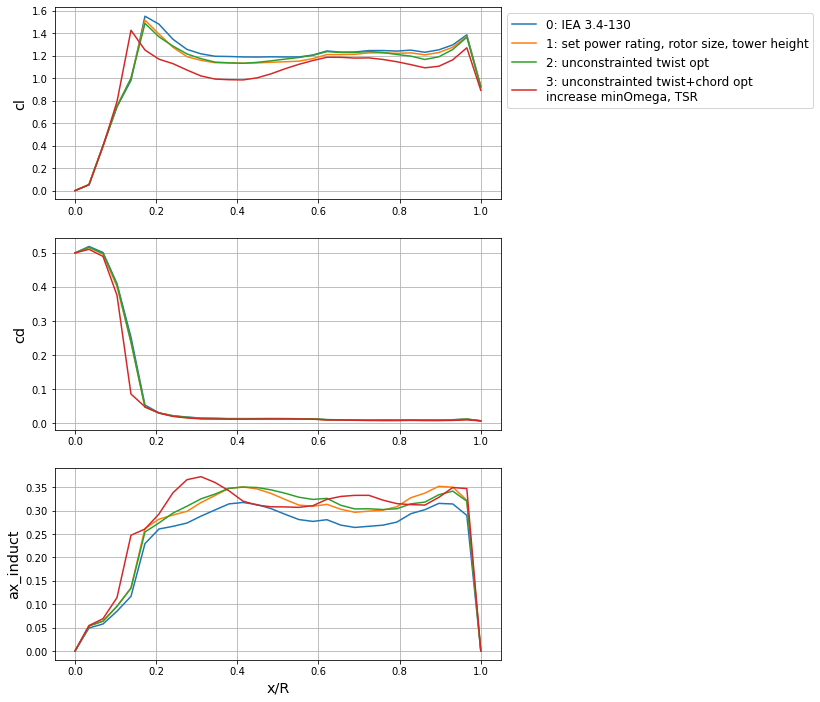

In [8]:
sectional_quantities = ['cl','cd','ax_induct']

Nplot = len(sectional_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aero_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    xs = turb['wt.wt_init.blade.outer_shape_bem.compute_blade_outer_shape_bem.s_default']['value']
    for i,qty in enumerate(sectional_quantities):
        val = turb[f'wt.rp.powercurve.compute_power_curve.{qty}_regII']['value']
        ax[i].plot(xs,val,label=legendnames[istep])
        ax[i].set_ylabel(qty,fontsize='x-large')
    ax[-1].set_xlabel('x/R',fontsize='x-large')
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
for axi in ax:
    axi.grid()
    
fig.savefig(os.path.join(figdir,prefix+'_sectionalaero.png'),bbox_inches='tight')

outputs.0/refturb_output.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl


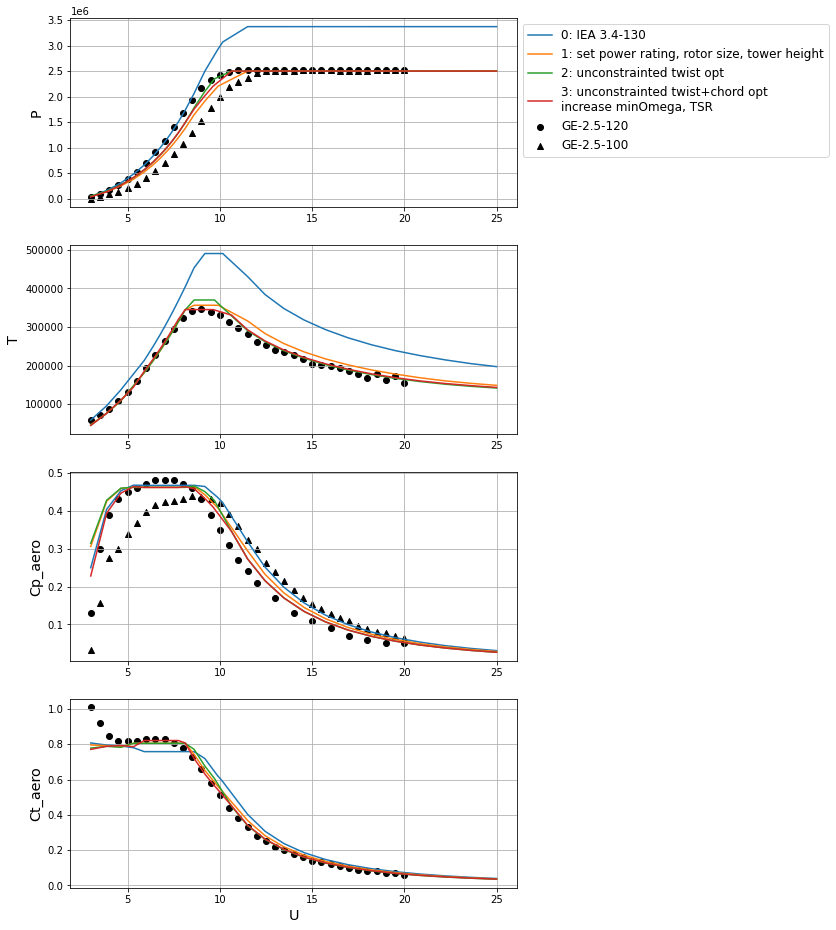

In [9]:
powercurve_quantities = ['P','T','Cp_aero','Ct_aero']

Nplot = len(powercurve_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aero_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    ws = turb['wt.rp.powercurve.compute_power_curve.V']['value']
    for i,qty in enumerate(powercurve_quantities):
        val = turb[f'wt.rp.powercurve.compute_power_curve.{qty}']['value']
        ax[i].plot(ws,val,label=legendnames[istep])
        ax[i].set_ylabel(qty,fontsize='x-large')
    ax[-1].set_xlabel('U',fontsize='x-large')
for axi in ax:
    axi.grid()

# add reference data
for i,qty in enumerate(powercurve_quantities):
    for iref,(refname,refvals) in enumerate(ref.items()):
        if qty in refvals.columns:
            ax[i].scatter(refvals.index,refvals[qty],color='k',marker=markers[iref],label=refname)
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
    
fig.savefig(os.path.join(figdir,prefix+'_aero.png'),bbox_inches='tight')

## struct design

In [10]:
for istep in aerostruct_opt_steps:
    print(f'Step {istep}:')
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    flapfreqs = turb['wt.rs.frame.flap_mode_freqs']['value']
    edgefreqs = turb['wt.rs.frame.edge_mode_freqs']['value']
    print('flap mode freqs [Hz]:',flapfreqs)
    print('edge mode freqs [Hz]:',edgefreqs)
    Omg = turb['wt.rp.powercurve.compute_power_curve.rated_Omega']['value'][0]/60.
    print('3P, 6P freqs [Hz]:',3*Omg,6*Omg)
    print('')
    assert (flapfreqs[0] > 1.1*3*Omg), 'WARNING: 1st flap freq too low'
    assert (edgefreqs[0] > flapfreqs[0]), 'WARNING: 1st edge freq less than flap freq'
    assert (flapfreqs[1] > 1.1*6*Omg), 'WARNING: 1st flap freq too low'
    assert (edgefreqs[1] > flapfreqs[1]), 'WARNING: 1st edge freq less than flap freq'

Step 0:
outputs.0/refturb_output.pkl
flap mode freqs [Hz]: [ 0.78889975  2.41628506  5.24344348  8.5566819  11.69741431]
edge mode freqs [Hz]: [ 1.06971186  3.21843571  7.32034512 13.27322807 19.71158002]
3P, 6P freqs [Hz]: 0.5876490206469983 1.1752980412939966

Step 1:
outputs.1/NREL-2_5-116-step1.pkl
flap mode freqs [Hz]: [ 0.97604648  3.0152655   6.56522525 10.72192043 14.6604051 ]
edge mode freqs [Hz]: [ 1.33243197  4.02725351  9.17451754 16.63600098 24.69703198]
3P, 6P freqs [Hz]: 0.6050000000000001 1.2100000000000002

Step 2:
outputs.2/NREL-2_5-116-step2.pkl
flap mode freqs [Hz]: [ 0.9773733   3.02041542  6.56144653 10.68431892 14.73209766]
edge mode freqs [Hz]: [ 1.32926148  4.02305597  9.20417687 16.56487877 24.6926715 ]
3P, 6P freqs [Hz]: 0.6050000000000001 1.2100000000000002

Step 3:
outputs.3/NREL-2_5-116-step3.pkl
flap mode freqs [Hz]: [ 0.9420758   2.72498904  5.81680712  9.50559103 13.30722088]
edge mode freqs [Hz]: [ 1.2771753   3.73187451  8.57822109 15.3241891  22.8127

In [11]:
for istep in aerostruct_opt_steps:
    print(f'Step {istep}:')
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    towerFAfreqs = turb['wt.towerse.tower.x_mode_freqs']['value']
    towerSSfreqs = turb['wt.towerse.tower.y_mode_freqs']['value']
    print('tower fore-aft mode freqs [Hz]:',towerFAfreqs)
    print('tower side-side mode freqs [Hz]:',towerSSfreqs)
    Omg = turb['wt.rp.powercurve.compute_power_curve.rated_Omega']['value'][0]/60.
    print('1P, 2P freqs [Hz]:',1*Omg,2*Omg)
#     assert (towerFAfreqs[0] > Omg), 'WARNING: 1st FA freq too low'
#     assert (towerSSfreqs[0] > Omg), 'WARNING: 1st SS freq too low'
#     assert (towerFAfreqs[0] < 2*Omg), 'WARNING: 1st FA freq too high'
#     assert (towerSSfreqs[0] < 2*Omg), 'WARNING: 1st SS freq too high'
    if (towerFAfreqs[0] < Omg):
        print('WARNING: 1st FA freq too low')
    if (towerSSfreqs[0] < Omg):
        print('WARNING: 1st SS freq too low')
    if (towerFAfreqs[0] > 2*Omg):
        print('WARNING: 1st FA freq too high')
    if (towerSSfreqs[0] > 2*Omg):
        print('WARNING: 1st SS freq too high')
    print('')
        

Step 0:
outputs.0/refturb_output.pkl
tower fore-aft mode freqs [Hz]: [0.41121296 1.79356102 3.54987751]
tower side-side mode freqs [Hz]: [0.40839708 1.60832551 3.30566907]
1P, 2P freqs [Hz]: 0.19588300688233276 0.3917660137646655

Step 1:
outputs.1/NREL-2_5-116-step1.pkl
tower fore-aft mode freqs [Hz]: [0.6769662  2.73274827 5.71195146]
tower side-side mode freqs [Hz]: [0.67062419 2.41655619 5.50943387]
1P, 2P freqs [Hz]: 0.2016666666666667 0.4033333333333334

Step 2:
outputs.2/NREL-2_5-116-step2.pkl
tower fore-aft mode freqs [Hz]: [0.6894923  2.8037538  5.97026398]
tower side-side mode freqs [Hz]: [0.68275566 2.4709345  5.77684496]
1P, 2P freqs [Hz]: 0.2016666666666667 0.4033333333333334

Step 3:
outputs.3/NREL-2_5-116-step3.pkl
tower fore-aft mode freqs [Hz]: [0.67639949 2.82617131 6.02033316]
tower side-side mode freqs [Hz]: [0.67021626 2.49734111 5.82548376]
1P, 2P freqs [Hz]: 0.21871186681084623 0.43742373362169246

Step 4:
outputs.4/NREL-2_5-116-step4.pkl
tower fore-aft mode freq

## mass optimization

In [12]:
for istep in aerostruct_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    blade_mass = turb['wt.re.precomp.blade_mass']['value'][0]
    print(f'Step {istep}: blade mass= {blade_mass:g} kg')

outputs.0/refturb_output.pkl
Step 0: blade mass= 14576.9 kg
outputs.1/NREL-2_5-116-step1.pkl
Step 1: blade mass= 13007.1 kg
outputs.2/NREL-2_5-116-step2.pkl
Step 2: blade mass= 13005.4 kg
outputs.3/NREL-2_5-116-step3.pkl
Step 3: blade mass= 12821.5 kg
outputs.4/NREL-2_5-116-step4.pkl
Step 4: blade mass= 10816.9 kg
outputs.5/NREL-2_5-116-step5.pkl
Step 5: blade mass= 10816.9 kg


In [13]:
for istep in aerostruct_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    tower_mass = turb['wt.towerse.geom.turb.tower_mass']['value'][0]
    print(f'Step {istep}: tower mass= {tower_mass:g} kg')

outputs.0/refturb_output.pkl
Step 0: tower mass= 620441 kg
outputs.1/NREL-2_5-116-step1.pkl
Step 1: tower mass= 437799 kg
outputs.2/NREL-2_5-116-step2.pkl
Step 2: tower mass= 406897 kg
outputs.3/NREL-2_5-116-step3.pkl
Step 3: tower mass= 388048 kg
outputs.4/NREL-2_5-116-step4.pkl
Step 4: tower mass= 370777 kg
outputs.5/NREL-2_5-116-step5.pkl
Step 5: tower mass= 240478 kg


## final outputs

In [14]:
fpath = glob.glob(f'outputs.{aerostruct_opt_steps[-1]}/*.pkl')[0]
print(fpath)
pkl = pickle.load(open(fpath,'rb'))
final = {keyval[0]: keyval[1] for keyval in pkl}

outputs.5/NREL-2_5-116-step5.pkl


In [15]:
wspd = final['wt.rp.powercurve.compute_power_curve.V']['value']
wspd, final['wt.rp.powercurve.compute_power_curve.V']['units']

(array([ 3.        ,  3.86273619,  4.63694913,  5.31786553,  5.90128733,
         6.38361754,  6.76188242,  7.03374985,  7.19754368,  7.25225405,
         7.30696443,  7.47075826,  7.74262569,  8.12089057,  8.60322077,
         9.18664257,  9.63572966, 10.64177192, 11.50450811, 12.45044849,
        13.47376103, 14.56813667, 15.72682822, 16.94269195, 18.20823166,
        19.51564489, 20.85687099, 22.22364086, 23.6075279 , 25.        ]),
 'm/s')

In [16]:
Cp = final['wt.rp.powercurve.compute_power_curve.Cp']['value']
Cp

array([0.22746235, 0.37050422, 0.41591865, 0.42957618, 0.42917412,
       0.42981197, 0.43016118, 0.43034696, 0.43043698, 0.43046298,
       0.43048789, 0.43055264, 0.43063048, 0.43159435, 0.4255324 ,
       0.40101263, 0.37951626, 0.32026073, 0.25347879, 0.19998208,
       0.15778842, 0.12483425, 0.09922608, 0.07936004, 0.06393596,
       0.05192641, 0.04254044, 0.03516427, 0.02933579, 0.02470165])

In [17]:
Ct = final['wt.rp.powercurve.compute_power_curve.Ct_aero']['value']
Ct

array([0.78231538, 0.79608521, 0.79606152, 0.78545664, 0.81206779,
       0.81206779, 0.81206779, 0.81206779, 0.81206779, 0.81206779,
       0.81206779, 0.81206779, 0.81206779, 0.80319411, 0.71565827,
       0.62764517, 0.5705039 , 0.4499777 , 0.3409447 , 0.26243266,
       0.20421349, 0.16053255, 0.12749132, 0.10237504, 0.08309156,
       0.06826743, 0.05679264, 0.04786057, 0.04091116, 0.03541342])

In [18]:
genpower_W = final['wt.rp.powercurve.compute_power_curve.P']['value']
genpower_kW = genpower_W / 1000.
genpower_W, final['wt.rp.powercurve.compute_power_curve.P']['units']

(array([  39780.25270876,  138316.04215758,  268596.05840177,
         418452.80844662,  571305.03667636,  724224.68557131,
         861446.47771956,  970004.4703878 , 1039577.19239354,
        1063528.37589637, 1087842.85113296, 1162825.51793824,
        1294684.06010602, 1497203.97681342, 1755133.17782893,
        2013829.74255914, 2199269.51457275, 2499998.60953861,
        2500000.08750725, 2500001.79773005, 2499976.29835754,
        2500000.10528215, 2500020.1294615 , 2500019.38058177,
        2500015.76944392, 2499949.47843621, 2500021.15684505,
        2500008.50088099, 2500020.89669473, 2500001.34981142]), 'W')

In [19]:
rotpower_W = final['wt.rp.powercurve.compute_power_curve.P_aero']['value']
rotpower_kW = rotpower_W / 1000.
rotpower_W, final['wt.rp.powercurve.compute_power_curve.P_aero']['units']

(array([  43070.03096382,  149754.60970889,  290808.62398794,
         453058.34401421,  617219.57336961,  781267.90702011,
         928543.49320155, 1045105.57299053, 1119830.60766464,
        1145561.56795328, 1171683.69603828, 1252256.9690902 ,
        1394004.57463542, 1611850.85814657, 1889547.0755134 ,
        2168234.12417582, 2367891.9369303 , 2691678.53718622,
        2691680.12847369, 2691681.96982272, 2691654.51536198,
        2691680.14761143, 2691701.70708494, 2691700.90078709,
        2691697.01277603, 2691625.63910327, 2691702.81324006,
        2691689.18691774, 2691702.53314348, 2691681.48756127]), 'W')

In [20]:
thrust_N = final['wt.rp.powercurve.compute_power_curve.T']['value']
thrust_kN = thrust_N / 1000.
thrust_N, final['wt.rp.powercurve.compute_power_curve.T']['units']

(array([ 45605.64697898,  76938.5324879 , 110867.82785435, 143876.92976641,
        183180.84087859, 214348.39933605, 240503.69639731, 260231.79897736,
        272492.87058538, 276651.1915459 , 280841.00129468, 293572.85281272,
        315328.37609342, 343101.07076516, 343101.06984934, 343101.07076516,
        343101.07076513, 330075.37894452, 292290.22659071, 263500.91114657,
        240135.49238958, 220681.20818407, 204247.69339165, 190350.11537539,
        178437.72528247, 168412.22510566, 160023.81751126, 153109.64717134,
        147685.23105953, 143364.67254853]), 'N')

In [21]:
torque_Nm = final['wt.rp.powercurve.compute_power_curve.Q']['value']
torque_kNm = torque_Nm / 1000.
torque_Nm, final['wt.rp.powercurve.compute_power_curve.Q']['units']

(array([  51411.06244998,  178756.39788564,  347127.22499305,
         540798.5621641 ,  676531.76184581,  791641.19760624,
         888239.12300926,  961099.8432262 , 1006382.98712543,
        1021740.68606518, 1037214.68082111, 1084236.53036468,
        1164585.0123586 , 1283856.42323024, 1420665.74939449,
        1577807.2935638 , 1723096.74808743, 1958713.76644619,
        1958714.92441384, 1958716.26434936, 1958696.28594946,
        1958714.93834022, 1958730.62700326, 1958730.04026651,
        1958727.21099077, 1958675.27291813, 1958731.43194382,
        1958721.51617389, 1958731.2281197 , 1958715.91341141]), 'N*m')

In [22]:
pitch_deg = final['wt.rp.powercurve.compute_power_curve.pitch']['value']
pitch_deg, final['wt.rp.powercurve.compute_power_curve.pitch']['units']

(array([ 4.17304626,  3.55985771,  2.69053502,  1.74275073,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.1810828 ,  2.8301298 ,
         4.09919305,  4.80615547,  6.63842423,  8.80963774, 10.75983791,
        12.59700298, 14.38035711, 16.10303343, 17.80697596, 19.45307489,
        21.0825071 , 22.67360253, 24.21650402, 25.74360541, 27.22463336]),
 'deg')

In [23]:
rotspd_RPM = final['wt.rp.powercurve.compute_power_curve.Omega']['value']
rotspd_RPM, final['wt.rp.powercurve.compute_power_curve.Omega']['units']

(array([ 8.        ,  8.        ,  8.        ,  8.        ,  8.71210059,
         9.42416713,  9.98260151, 10.38396078, 10.62577044, 10.70653965,
        10.78730886, 11.02911852, 11.4304778 , 11.98891217, 12.70097871,
        13.12271201, 13.12271201, 13.12271201, 13.12271201, 13.12271201,
        13.12271201, 13.12271201, 13.12271201, 13.12271201, 13.12271201,
        13.12271201, 13.12271201, 13.12271201, 13.12271201, 13.12271201]),
 'rpm')

In [24]:
TSR = rotspd_RPM * 2*np.pi/60 * (D/2) / wspd

In [25]:
df = pd.DataFrame(
    data={
        'aerodynamic power [kW]': rotpower_kW,
        'generator power [kW]': genpower_kW,
        'rotor thrust [kN]': thrust_kN,
        'rotor torque [kN-m]': torque_kNm,
        'rotor speed [RPM]': rotspd_RPM,
        'blade pitch [deg]': pitch_deg,
        'tip-speed ratio [-]': TSR,
    },
    index=pd.Index(wspd,name='wind speed [m/s]'))

df.to_csv(os.path.join('..',prefix+'.csv'))

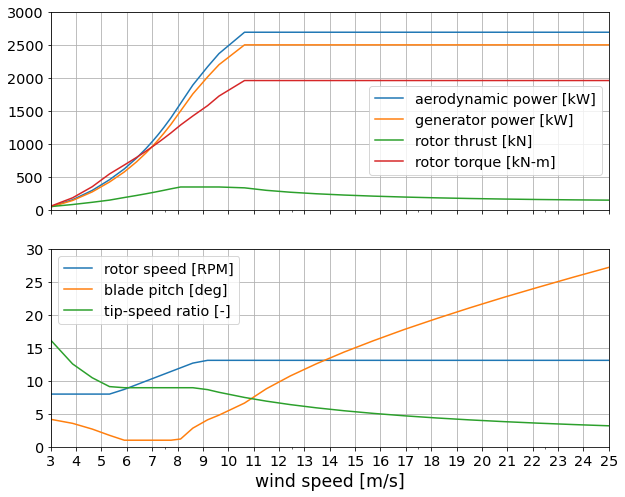

In [26]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,8))

df[['aerodynamic power [kW]','generator power [kW]','rotor thrust [kN]','rotor torque [kN-m]']].plot(ax=ax[0])
ax[0].set_ylim((0,3000))

df[['rotor speed [RPM]','blade pitch [deg]','tip-speed ratio [-]']].plot(ax=ax[1])
ax[1].set_ylim((0,30))

for axi in ax:
    xticks = np.arange(3,26)
    axi.set_xticks(xticks)
    axi.set_xlim((xticks[0],xticks[-1]))
    axi.grid()
    axi.tick_params(labelsize='x-large')
    axi.legend(loc='best',fontsize='x-large')
axi.set_xlabel('wind speed [m/s]',fontsize='xx-large')
ax[0].legend(loc='center right',bbox_to_anchor=(1,0.4),fontsize='x-large') # need small adjustment in position
    
fig.savefig(os.path.join(figdir,prefix+'_design_overview.png'),bbox_inches='tight')